In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/Users/zgubic/Projects/FairMass/fairmass')
import plotting
import generate
import models
import actions

# Pivoting NLL GIF

Animation showing the evolution of the classifier predictions when using the NLL adversary.

In [2]:
sess = tf.InteractiveSession()
ctr = 0

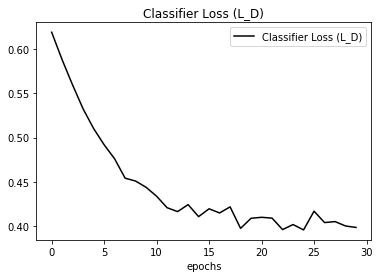

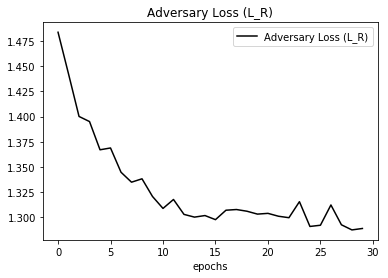

In [3]:
n_samples = 10000
n_epochs = 30
n_adv_cycles = 2
n_components = 5
n_clf = 1
n_adv = 5
lam = 50
ctr+=1
name = 'name'+str(ctr)
    
# input placeholders
x_in = tf.placeholder(tf.float32, shape=[n_samples, 2], name='X12')
y_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Y')
z_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Z')
inputs = [x_in, y_in, z_in]

# create the classifier graph, loss, and optimisation
clf_output, vars_D = models.classifier(x_in, name+'_clf')
loss_D = models.classifier_loss(clf_output, y_in)
opt_D = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_D, var_list=vars_D)

# create the adversary graph, loss, and optimisation
adv_output, vars_R = models.adversary_gaussmix(clf_output, n_components, name+'_adv')
loss_R = models.adversary_gaussmix_loss(z_in, adv_output, n_components)
opt_R = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss_R, var_list=vars_R)

# create the combined loss function (for the classifier)
loss_DR = loss_D - lam*loss_R
opt_DR = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss_DR, var_list=vars_D)

# initialise the variables
sess.run(tf.global_variables_initializer())

# pretrain the classifier
actions.train(sess, opt_D, loss_D, inputs, generate.generate_toys, n_samples, n_epochs, 'Classifier Loss (L_D)')

# pretrain the adversary
actions.train(sess, opt_R, loss_R, inputs, generate.generate_toys, n_samples, n_epochs, 'Adversary Loss (L_R)')

# now do the adversarial part (modifed loss function for the classifier)
losses = [loss_D, loss_R, loss_DR]
opts = [None, opt_R, opt_DR]
X, Y, Z = generate.generate_toys(n_samples)
feed_dict = {x_in:X, y_in:Y, z_in:Z}

In [4]:
NLLs = []
plot_names = []
for cycle in range(n_adv_cycles):
    
    # training step
    print(cycle)
    actions.train_adversarially(sess, losses, opts, inputs, generate.generate_toys, n_samples, 1, n_clf, n_adv, None)
    
    # evaluate the graphs
    NLL, fX = sess.run([loss_R, clf_output], feed_dict=feed_dict)
    NLLs.append(NLL)
    fX = fX.reshape(-1)
    
    #####################
    # Z density plot
    #####################
    
    plot_name = 'Z_density_slices'
    plot_names.append(plot_name)
    dirn = 'media/plots/{}'.format(plot_name)
    if not os.path.exists(dirn):
        os.makedirs(dirn)
    path = '{d}/{p}_{c:03}.png'.format(d=dirn, p=plot_name, c=cycle)
        
    plotting.plot_Z_density(Z, fX, NLLs, n_adv_cycles, n_curves=3, pname=path)
    
    #####################
    # Classifier performance plot
    #####################
    
    plot_name = 'Clf_perf'
    plot_names.append(plot_name)
    dirn = 'media/plots/{}'.format(plot_name)
    if not os.path.exists(dirn):
        os.makedirs(dirn)
    path = '{d}/{n}_{c:03}.png'.format(d=dirn, n=plot_name, c=cycle)
                                    
    plotting.plot_classifier_performance(x_in, y_in, clf_output, generate.generate_toys, sess, path)
    

for pname in plot_names:
    dirn = 'media/plots/{}'.format(pname)
    os.system('convert -loop 0 -delay 20 {d}/{p}*.png media/gifs/{p}_{c}.gif'.format(d=dirn, p=pname, c=n_adv_cycles))
    #os.system('rm {d}/{p}_*.png'.format(d=dirn, p=pname))

0
1
